#### Top

# Chapter 10 Porting

* [10.0 Imports and Setup](#10.0-Imports-and-Setup)
* [10.1 The Code](#10.1-The-Code)
* [10.2 Multiplication Diversion](#10.2-Multiplication-Diversion)

---
# 10.0 Imports and Setup

[back to Top](#Top)

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import chardet
import pprint as pp
# import hvplot.polars
# hvplot.extension('matplotlib')

def HR():
    print("-"*40)

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.options.mode.copy_on_write = True
print(f"Pandas copy-on-write: {pd.options.mode.copy_on_write}")
pl.Config.set_verbose(True)

print(f"Thread pool size: {pl.thread_pool_size()}")
print(f"Index type: {pl.get_index_type()}")
pl.show_versions()
HR()
pp.pprint(pl.Config.state(if_set=True))

@pl.Config(tbl_cols=-1, ascii_tables=True)
def tight_layout(df: pl.DataFrame, n=5) -> None:
    with pl.Config(tbl_cols=-1, fmt_str_lengths=n):
        print(df)

def detect_encoding(filename: str) -> str:
    """Return the most probable character encoding for a file."""
    with open(filename, "rb") as f:
        raw_data = f.read()
        print(raw_data)
        result = chardet.detect(raw_data)
        return result["encoding"]

Pandas copy-on-write: True
Thread pool size: 4
Index type: UInt32
--------Version info---------
Polars:              1.9.0
Index type:          UInt32
Platform:            macOS-12.7.6-x86_64-i386-64bit
Python:              3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager  1.1.0
altair               5.4.0
cloudpickle          3.0.0
connectorx           0.3.3
deltalake            0.19.1
fastexcel            0.11.6
fsspec               2023.12.2
gevent               24.2.1
great_tables         0.10.0
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.0.2
openpyxl             3.1.5
pandas               2.2.2
pyarrow              17.0.0
pydantic             2.8.2
pyiceberg            0.6.1
sqlalchemy           2.0.32
torch                <not installed>
xlsx2csv             0.8.3
xlsxwriter           3.2.0
----------------------------------------
{'POLARS_VERBOSE': '1',
 'set_decimal_separ

In [2]:
%%timeit
@pl.Config(set_verbose=False)
def timing_test():
    pass

# timing_test()

80.3 µs ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


---
## 10.0.1 yfinance

* Download market data from Yahoo! Finance's API 
* https://github.com/ranaroussi/yfinance?tab=readme-ov-file
* https://aroussi.com/post/python-yahoo-finance

data/USDJPY=X.csv
----------------------------------------
The file data/USDJPY=X.csv does not exist,
Writing to data/USDJPY=X.csv,
Done.


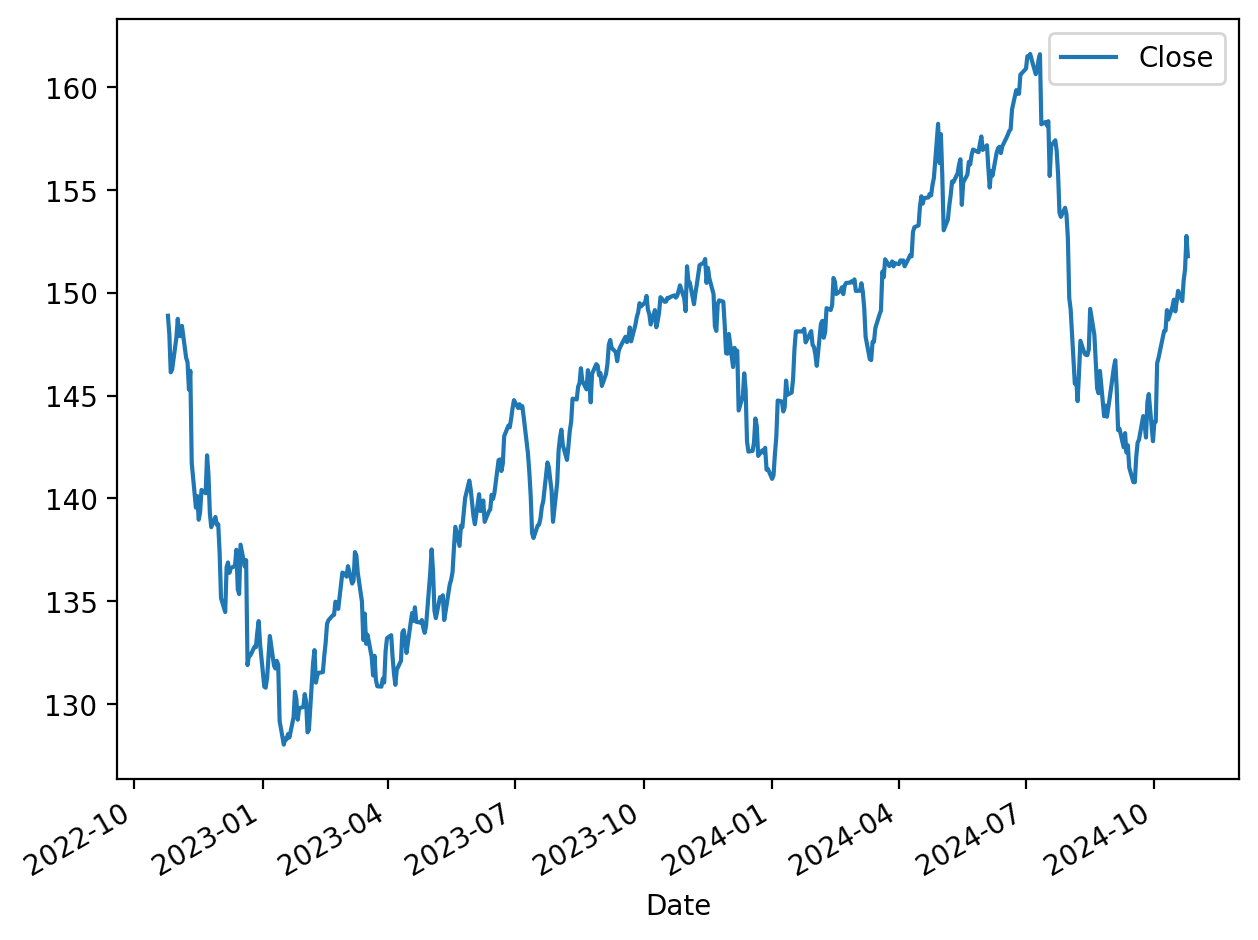

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path

FIRM = True

# X in USDJPY=X means that this is a forex cross-rate
# Sometimes JPY=X is used as short-cut for USDJPY=X
symbol = "USDJPY=X"
REUSE = False

data = yf.Ticker(symbol)

file_path = Path(f"./data/{symbol}.csv")
print(file_path)
HR()

if (file_path.exists() and REUSE):
    print(f"The file {file_path} exists.")
else:
    print(f"The file {file_path} does not exist,")
    print(f"Writing to {file_path},")
    # get historical market data
    hist_raw = data.history(period="2y")
    # Create csv file
    hist_raw.to_csv(file_path)
    #hist_raw.to_csv("./data/raw-yfinance.csv")
    print("Done.")

# hist = pd.read_csv(file_path)
# hist.tail()
hist_raw.plot(y="Close")
plt.tight_layout()

In [4]:
hist_raw[["Close"]].tail(5).round(2).sort_values(by=['Date'], ascending=False)

,Close
Date,
2024-10-25 00:00:00+01:00,151.78
2024-10-24 00:00:00+01:00,152.77
2024-10-23 00:00:00+01:00,151.14
2024-10-22 00:00:00+01:00,150.60
2024-10-21 00:00:00+01:00,149.60


---
## 10.0.2 Example setup

In [5]:
data = yf.download('^GSPC QCOM TSLA NFLX DIS PG MMM IBM BRK-B UPS F', period="6mo")
data.to_csv("./data/raw-yfinance.csv")

[*********************100%%**********************]  11 of 11 completed


---
# 10.1 The Code
[back to Top](#Top)


**Fixed code**

To avoid the Pandas warning message, you should use `.iloc[]` for integer-based indexing and `.loc[]` for label-based indexing. 




In [6]:
# Chapter 13: Portfolio Management System

K = 1000000
lot = 100
port_tickers = [
    'QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B','UPS','F'
]
bm_ticker = '^GSPC'
ticker_list = [bm_ticker] + port_tickers
df_data= { 
'Beta':[
    1.34,2,0.75,1.2,0.41,0.95,1.23,0.9,1.05,1.15
],
'Shares':[
    -1900,-100,-400,-800,-5500,1600,1800,2800,1100,20800
],
'rSL':[
    42.75,231,156,54.2,37.5,42.75,29.97,59.97,39.97,2.10
]
}
port = pd.DataFrame(df_data,index=port_tickers)
port['Side'] = np.sign(port['Shares'])

raw_data = pd.read_csv('data/raw-yfinance.csv', index_col=0, header=[0,1])
price_df = round(raw_data['Close'], 2)

# This syntax causes a warning
# bm_cost = price_df[bm_ticker][0]
# bm_price = price_df[bm_ticker][-1]

# Fixed code
bm_cost = price_df.loc[price_df.index[0], bm_ticker]
bm_price = price_df.loc[price_df.index[-1], bm_ticker]


port['rCost'] = round(price_df.iloc[0,:].div(bm_cost) *1000, 2)
port['rPrice'] = round(price_df.iloc[-1,:].div(bm_price) *1000, 2)
port['Cost'] = price_df.iloc[0,:]
port['Price'] = price_df.iloc[-1,:]

print(port)

       Beta  Shares     rSL  Side   rCost  rPrice    Cost   Price
QCOM   1.34   -1900   42.75    -1   32.35   28.93  163.30  168.10
TSLA   2.00    -100  231.00    -1   33.71   44.83  170.18  260.48
NFLX   0.75    -400  156.00    -1  111.88  129.87  564.80  754.55
DIS    1.20    -800   54.20    -1   22.34   16.42  112.77   95.40
PG     0.41   -5500   37.50    -1   32.20   29.20  162.55  169.62
MMM    0.95    1600   42.75     1   18.11   21.77   91.41  126.47
IBM    1.23    1800   29.97     1   33.46   37.59  168.91  218.39
BRK-B  0.90    2800   59.97     1   80.21   78.79  404.91  457.77
UPS    1.05    1100   39.97     1   29.20   23.81  147.39  138.35
F      1.15   20800    2.10     1    2.58    1.93   13.04   11.24


**Part 2: Calculate return on data**

In [7]:
price_df['bm returns'] = round(np.exp(np.log(price_df[bm_ticker]/
                        price_df[bm_ticker].shift()).cumsum()) - 1, 3)
rel_price = round(price_df.div(price_df['^GSPC'],axis=0 )*1000,2)

rMV = rel_price.mul(port['Shares'])
rLong_MV = rMV[rMV >0].sum(axis=1)
rShort_MV = rMV[rMV <0].sum(axis=1)
rMV_Beta = rMV.mul(port['Beta'])
rLong_MV_Beta = rMV_Beta[rMV_Beta >0].sum(axis=1) / rLong_MV
rShort_MV_Beta = rMV_Beta[rMV_Beta <0].sum(axis=1)/ rShort_MV

price_df['rNet_Beta'] = rLong_MV_Beta - rShort_MV_Beta
price_df['rNet'] = round((rLong_MV + rShort_MV)
                         .div(abs(rMV).sum(axis=1)),3)

price_df['rReturns_Long'] = round(
    np.exp(np.log(rLong_MV/rLong_MV.shift()).cumsum())-1,3)
price_df['rReturns_Short'] = - round(
    np.exp(np.log(rShort_MV/rShort_MV.shift()).cumsum())-1,3)
price_df['rReturns'] = price_df['rReturns_Long'] + \
    price_df['rReturns_Short']

MV = price_df.mul(port['Shares'])
Long_MV = MV[MV >0].sum(axis=1)
Short_MV = MV[MV <0].sum(axis=1)
price_df['Gross'] = round((Long_MV - Short_MV).div(K),3)
price_df['Net'] = round((Long_MV + Short_MV).div(abs(MV).sum(axis=1)),3)

price_df['Returns_Long'] = round(
    np.exp(np.log(Long_MV/Long_MV.shift()).cumsum())-1,3)
price_df['Returns_Short'] = -round(
    np.exp(np.log(Short_MV/Short_MV.shift()).cumsum())-1,3)
price_df['Returns'] = price_df['Returns_Long'] + price_df['Returns_Short']

MV_Beta = MV.mul(port['Beta'])
Long_MV_Beta = MV_Beta[MV_Beta >0].sum(axis=1) / Long_MV
Short_MV_Beta = MV_Beta[MV_Beta <0].sum(axis=1)/ Short_MV
price_df['Net_Beta'] = Long_MV_Beta - Short_MV_Beta

print(price_df)

Ticker       BRK-B     DIS      F     IBM     MMM    NFLX      PG    QCOM  \
Date                                                                        
2024-04-25  404.91  112.77  13.04  168.91   91.41  564.80  162.55  163.30   
2024-04-26  402.10  112.73  12.79  167.13   91.83  561.23  161.29  165.66   
2024-04-29  400.96  112.08  12.75  167.43   92.16  559.49  161.66  169.20   
2024-04-30  396.73  111.10  12.15  166.20   96.51  550.64  163.20  165.85   
2024-05-01  398.58  110.48  12.20  164.43   98.44  551.71  163.40  164.11   
...            ...     ...    ...     ...     ...     ...     ...     ...   
2024-10-18  464.80   97.28  11.10  232.20  135.14  763.89  171.28  170.92   
2024-10-21  464.16   96.62  10.88  231.75  134.84  772.07  169.54  169.01   
2024-10-22  461.45   96.74  11.11  232.25  131.73  764.24  169.70  173.18   
2024-10-23  460.61   96.24  11.06  232.75  127.91  749.29  169.58  166.60   
2024-10-24  457.77   95.40  11.24  218.39  126.47  754.55  169.62  168.10   

In [8]:
# price_df['bm returns']

In [9]:
# price_df['rNet_Beta']

---
# 10.2 Multiplication Diversion
[back to Top](#Top)

Let’s look at the multiplication of a row and a dataframe. Here’s a simple example.

Let’s make a dataframe of folks’ daily consumption of various food groups. We’ll also create a series with the number of days for each person. Consider calculating the total consumption of each food group for each person. We can do this by multiplying the number of days by the consumption of each food group.

In [10]:
days = pd.Series([10, 11, 9], index=['Suzy', 'Bob', 'Alice'])
days

Suzy     10
Bob      11
Alice     9
dtype: int64

In [11]:
# Pay attention to the index here
daily_consumption = pd.DataFrame({
    'Suzy': [.2, .9, .1],
    'Bob': [.3, .2, .8],
    'Alice': [.5, .1, .1],
    'Joe': [.1, .8, .0]},
    index=['meat', 'plants', 'dairy']
)
daily_consumption

,Suzy,Bob,Alice,Joe
meat,0.2,0.3,0.5,0.1
plants,0.9,0.2,0.1,0.8
dairy,0.1,0.8,0.1,0.0


Multiply the days series by the daily_consumption DataFrame.

In Pandas, this math works because Pandas aligns the index names with the column names. Polars doesn’t have an index, so we need to do a little more work.

In [12]:
daily_consumption * days

,Alice,Bob,Joe,Suzy
meat,4.5,3.3,NaN,2.0
plants,0.9,2.2,NaN,9.0
dairy,0.9,8.8,NaN,1.0


* Convert this code to Polars

In [13]:
import polars as pl

days_pl = pl.DataFrame(days.reset_index())
days_pl

index,0
str,i64
"""Suzy""",10
"""Bob""",11
"""Alice""",9


In [14]:
daily_consumption_pl = pl.DataFrame(daily_consumption.reset_index())
daily_consumption_pl

index,Suzy,Bob,Alice,Joe
str,f64,f64,f64,f64
"""meat""",0.2,0.3,0.5,0.1
"""plants""",0.9,0.2,0.1,0.8
"""dairy""",0.1,0.8,0.1,0.0


Try the multiplication in Polars

In [15]:
try:
    daily_consumption_pl * days_pl
except Exception as e:
    print(e)

mul operation not supported for dtypes `str` and `str`


* There is no easy way to do the multiplication in Polars.
* Loop over the entries in *days_pl* and create a list with the expressions to do the appropriate multiplication for each column.

In [16]:
[(name, i, val) for i, (name,val) in enumerate(days_pl.iter_rows())]

[('Suzy', 0, 10), ('Bob', 1, 11), ('Alice', 2, 9)]

* Build up a list of expressions using the comprehension.

In [17]:
(
    daily_consumption_pl
    .with_columns(
        [pl.col(name) * val 
         for i, (name, val) in enumerate(days_pl.iter_rows())]
    )
)

index,Suzy,Bob,Alice,Joe
str,f64,f64,f64,f64
"""meat""",2.0,3.3,4.5,0.1
"""plants""",9.0,2.2,0.9,0.8
"""dairy""",1.0,8.8,0.9,0.0


Alternatively, we can convert the row data into a dictionary and do the math with keys and values.

In [18]:
days_dict = days.to_dict()
days_dict

{'Suzy': 10, 'Bob': 11, 'Alice': 9}

In [19]:
(
    daily_consumption_pl
    .with_columns(
        [pl.col(name) * val 
        for name, val in days_dict.items()]
    )
)

index,Suzy,Bob,Alice,Joe
str,f64,f64,f64,f64
"""meat""",2.0,3.3,4.5,0.1
"""plants""",9.0,2.2,0.9,0.8
"""dairy""",1.0,8.8,0.9,0.0


 * Use this technique later to convert the Pandas code to Polars.

---


---
# 10.3 Leveraging AI
[back to Top](#Top)

https://www.perplexity.ai/search/describe-this-code-tell-me-wha-esLd3lJrRIyrwCaSxn9NHQ
    
```
Describe this code. Tell me what it is doing and what the goal is. Explain what the variables and the columns it creates are:

K = 1000000
lot = 100
port_tickers = [
    'QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B','UPS','F'
]
bm_ticker = '^GSPC'
ticker_list = [bm_ticker] + port_tickers
df_data= { 
'Beta':[
    1.34,2,0.75,1.2,0.41,0.95,1.23,0.9,1.05,1.15
],
'Shares':[
    -1900,-100,-400,-800,-5500,1600,1800,2800,1100,20800
],
'rSL':[
    42.75,231,156,54.2,37.5,42.75,29.97,59.97,39.97,2.10
]
}
port = pd.DataFrame(df_data,index=port_tickers)
port['Side'] = np.sign(port['Shares'])



raw_data = pd.read_csv('data/raw-yfinance.csv', index_col=0, header=[0,1])
price_df = round(raw_data['Close'], 2)

bm_cost = price_df[bm_ticker][0]
bm_price = price_df[bm_ticker][-1]

port['rCost'] = round(price_df.iloc[0,:].div(bm_cost) *1000, 2)
port['rPrice'] = round(price_df.iloc[-1,:].div(bm_price) *1000, 2)
port['Cost'] = price_df.iloc[0,:]
port['Price'] = price_df.iloc[-1,:]

####

price_df['bm returns'] = round(np.exp(np.log(price_df[bm_ticker]/
                        price_df[bm_ticker].shift()).cumsum()) - 1, 3)
rel_price = round(price_df.div(price_df['^GSPC'],axis=0 )*1000,2)

rMV = rel_price.mul(port['Shares'])
rLong_MV = rMV[rMV >0].sum(axis=1)
rShort_MV = rMV[rMV <0].sum(axis=1)
rMV_Beta = rMV.mul(port['Beta'])
rLong_MV_Beta = rMV_Beta[rMV_Beta >0].sum(axis=1) / rLong_MV
rShort_MV_Beta = rMV_Beta[rMV_Beta <0].sum(axis=1)/ rShort_MV

price_df['rNet_Beta'] = rLong_MV_Beta - rShort_MV_Beta
price_df['rNet'] = round((rLong_MV + rShort_MV)
                         .div(abs(rMV).sum(axis=1)),3)

price_df['rReturns_Long'] = round(
    np.exp(np.log(rLong_MV/rLong_MV.shift()).cumsum())-1,3)
price_df['rReturns_Short'] = - round(
    np.exp(np.log(rShort_MV/rShort_MV.shift()).cumsum())-1,3)
price_df['rReturns'] = price_df['rReturns_Long'] + \
    price_df['rReturns_Short']

MV = price_df.mul(port['Shares'])
Long_MV = MV[MV >0].sum(axis=1)
Short_MV = MV[MV <0].sum(axis=1)
price_df['Gross'] = round((Long_MV - Short_MV).div(K),3)
price_df['Net'] = round((Long_MV + Short_MV).div(abs(MV).sum(axis=1)),3)

price_df['Returns_Long'] = round(
    np.exp(np.log(Long_MV/Long_MV.shift()).cumsum())-1,3)
price_df['Returns_Short'] = -round(
    np.exp(np.log(Short_MV/Short_MV.shift()).cumsum())-1,3)
price_df['Returns'] = price_df['Returns_Long'] + price_df['Returns_Short']

MV_Beta = MV.mul(port['Beta'])
Long_MV_Beta = MV_Beta[MV_Beta >0].sum(axis=1) / Long_MV
Short_MV_Beta = MV_Beta[MV_Beta <0].sum(axis=1)/ Short_MV
price_df['Net_Beta'] = Long_MV_Beta - Short_MV_Beta

```

---
# 10.4 Code Review
[back to Top](#Top)

* Are global variables being used?
* Is the code organized into functions? • Is the code usage clear?
* Is there adequate documentation?
* Are there tests in place?


---
# 10.5 Enhancing Your Coding Process
[back to Top](#Top)

---
# 10.6 Analyzing Raw Data
[back to Top](#Top)

* Look at financial data fetched from Yahoo using the finance download function.
* This code creates a price_df dataframe object, which fetches and stores our financial data.
* Also instantiate a port object, a portfolio objct that contains the number of shares for our portfolio.


In [20]:
K = 1000000
lot = 100
port_tickers = ['QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B',
                'UPS','F']
bm_ticker = '^GSPC'
ticker_list = [bm_ticker] + port_tickers
df_data= {
    'Beta':[1.34,2,0.75,1.2,0.41,0.95,1.23,0.9,1.05,1.15],
    'Shares':[-1900,-100,-400,-800,-5500,1600,1800,2800,1100,20800],
    'rSL':[42.75,231,156,54.2,37.5,42.75,29.97,59.97,39.97,2.10]
}
port = pd.DataFrame(df_data,index=port_tickers) 
port['Side'] = np.sign(port['Shares'])
raw_data = pd.read_csv('data/raw-yfinance.csv', index_col=0, header=[0,1])
price_df = round(raw_data['Close'],2)

---
# 10.7 Creating a get_price function
[back to Top](#Top)

* Improve the structure and readability of our code by refactoring the process of pulling data into a new function, called get_price.
* This creates a dataframe similar to price_df.
* This is complicated since the Yahoo finance library returns Pandas dataframes with multi-index columns.
* Polars doesn't support multi-index columns, so we have to post-process the data.

In [21]:
# Download if necessary
# import yfinance as yf
# data = yf.download('^GSPC QCOM TSLA NFLX DIS PG MMM IBM BRK-B UPS F', period="6mo")
# data

In [22]:
import polars as pl
import polars.selectors as cs

def get_price():
    
    # read first two rows to get headers
    head_df = pl.read_csv(
        './data/raw-yfinance.csv', 
        n_rows=2 # Stop reading after reading n_rows
    )

    # get tickers from first row
    cols = ['_'.join([a, str(b)]) for a, b in zip(head_df.columns, head_df.row(0))]
    # print(cols)
    
    return (
        pl.read_csv(
            'data/raw-yfinance.csv', 
            has_header=False,
            skip_rows=3, 
            new_columns=cols
        )
        # convert first column to datatime
        .with_columns(
            pl.col('Price_Ticker')
            .str.to_datetime("%Y-%m-%d")
            #.str.to_datetime('%Y-%m-%d %H:%M:%S')
            #.str.to_datetime() # format inferred from data
        )
        .rename({'Price_Ticker':'Date'})
        .with_columns(
            pl.col('Date').alias('new_date')
        )
        # columns starting with Close
        .select(cs.matches(r'^(Date|Close.*)'))

        # column names look like:
        # Close_BRK-B, Close_duplicated_0_DIS, .. Close_duplicated_9_^GSPC
        # so rename columns by taking value in last position
        .pipe(lambda df_: df_.rename(dict(zip(
            df_.columns,
            [c.split('_')[-1] for c in df_.columns]
        ))))
    )

get_price()

Date,BRK-B,DIS,F,IBM,MMM,NFLX,PG,QCOM,TSLA,UPS,^GSPC
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-04-25 00:00:00,404.910004,112.769997,13.04,168.910004,91.410004,564.799988,162.550003,163.300003,170.179993,147.389999,5048.419922
2024-04-26 00:00:00,402.100006,112.730003,12.79,167.130005,91.830002,561.22998,161.289993,165.660004,168.289993,147.589996,5099.959961
2024-04-29 00:00:00,400.959991,112.080002,12.75,167.429993,92.160004,559.48999,161.660004,169.199997,194.050003,148.550003,5116.169922
2024-04-30 00:00:00,396.730011,111.099998,12.15,166.199997,96.510002,550.640015,163.199997,165.850006,183.279999,147.479996,5035.689941
2024-05-01 00:00:00,398.579987,110.480003,12.2,164.429993,98.440002,551.710022,163.399994,164.110001,179.990005,145.919998,5018.390137
…,…,…,…,…,…,…,…,…,…,…,…
2024-10-18 00:00:00,464.799988,97.279999,11.1,232.199997,135.139999,763.890015,171.279999,170.919998,220.699997,135.929993,5864.669922
2024-10-21 00:00:00,464.160004,96.620003,10.88,231.75,134.839996,772.070007,169.539993,169.009995,218.850006,131.330002,5853.97998
2024-10-22 00:00:00,461.450012,96.739998,11.11,232.25,131.729996,764.23999,169.699997,173.179993,217.970001,131.330002,5851.200195


* Fixing date format

In [23]:
import polars as pl
import polars.selectors as cs

def get_price():
    
    # read first two rows to get headers
    head_df = pl.read_csv(
        './data/raw-yfinance.csv', 
        n_rows=2 # Stop reading after reading n_rows
    )

    # get tickers from first row
    cols = ['_'.join([a, str(b)]) for a, b in zip(head_df.columns, head_df.row(0))]
    # print(cols)
    
    return (
        pl.read_csv(
            'data/raw-yfinance.csv', 
            has_header=False,
            skip_rows=3, 
            new_columns=cols
        )
        # convert first column to datatime
        .with_columns(
            pl.col('Price_Ticker')
            .str.to_datetime("%Y-%m-%d")
            #.str.to_datetime('%Y-%m-%d %H:%M:%S')
            #.str.to_datetime() # format inferred from data
        )
        .rename({'Price_Ticker':'Date'})
        .with_columns(
            pl.col('Date').alias('new_date')
        )
        # columns starting with Close
        .select(cs.matches(r'^(Date|Close.*)'))

        # column names look like:
        # Close_BRK-B, Close_duplicated_0_DIS, .. Close_duplicated_9_^GSPC
        # so rename columns by taking value in last position
        .pipe(lambda df_: df_.rename(dict(zip(
            df_.columns,
            [c.split('_')[-1] for c in df_.columns]
        ))))
        .with_columns(
            pl.col('Date')
            .cast(
                pl.Datetime(time_unit='ns', time_zone='UTC')
            )
        )
    )


tick_mine = get_price()
tick_mine

Date,BRK-B,DIS,F,IBM,MMM,NFLX,PG,QCOM,TSLA,UPS,^GSPC
"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-04-25 00:00:00 UTC,404.910004,112.769997,13.04,168.910004,91.410004,564.799988,162.550003,163.300003,170.179993,147.389999,5048.419922
2024-04-26 00:00:00 UTC,402.100006,112.730003,12.79,167.130005,91.830002,561.22998,161.289993,165.660004,168.289993,147.589996,5099.959961
2024-04-29 00:00:00 UTC,400.959991,112.080002,12.75,167.429993,92.160004,559.48999,161.660004,169.199997,194.050003,148.550003,5116.169922
2024-04-30 00:00:00 UTC,396.730011,111.099998,12.15,166.199997,96.510002,550.640015,163.199997,165.850006,183.279999,147.479996,5035.689941
2024-05-01 00:00:00 UTC,398.579987,110.480003,12.2,164.429993,98.440002,551.710022,163.399994,164.110001,179.990005,145.919998,5018.390137
…,…,…,…,…,…,…,…,…,…,…,…
2024-10-18 00:00:00 UTC,464.799988,97.279999,11.1,232.199997,135.139999,763.890015,171.279999,170.919998,220.699997,135.929993,5864.669922
2024-10-21 00:00:00 UTC,464.160004,96.620003,10.88,231.75,134.839996,772.070007,169.539993,169.009995,218.850006,131.330002,5853.97998
2024-10-22 00:00:00 UTC,461.450012,96.739998,11.11,232.25,131.729996,764.23999,169.699997,173.179993,217.970001,131.330002,5851.200195


In [24]:
tick_from_pd = pl.DataFrame(price_df.reset_index().astype(
    {'Date': 'datetime64[ns, UTC]'}
).loc[:, tick_mine.columns])

tick_from_pd

Date,BRK-B,DIS,F,IBM,MMM,NFLX,PG,QCOM,TSLA,UPS,^GSPC
"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-04-25 00:00:00 UTC,404.91,112.77,13.04,168.91,91.41,564.8,162.55,163.3,170.18,147.39,5048.42
2024-04-26 00:00:00 UTC,402.1,112.73,12.79,167.13,91.83,561.23,161.29,165.66,168.29,147.59,5099.96
2024-04-29 00:00:00 UTC,400.96,112.08,12.75,167.43,92.16,559.49,161.66,169.2,194.05,148.55,5116.17
2024-04-30 00:00:00 UTC,396.73,111.1,12.15,166.2,96.51,550.64,163.2,165.85,183.28,147.48,5035.69
2024-05-01 00:00:00 UTC,398.58,110.48,12.2,164.43,98.44,551.71,163.4,164.11,179.99,145.92,5018.39
…,…,…,…,…,…,…,…,…,…,…,…
2024-10-18 00:00:00 UTC,464.8,97.28,11.1,232.2,135.14,763.89,171.28,170.92,220.7,135.93,5864.67
2024-10-21 00:00:00 UTC,464.16,96.62,10.88,231.75,134.84,772.07,169.54,169.01,218.85,131.33,5853.98
2024-10-22 00:00:00 UTC,461.45,96.74,11.11,232.25,131.73,764.24,169.7,173.18,217.97,131.33,5851.2


In [25]:
import polars.testing as pt

try:
    pt.assert_frame_equal(tick_mine, tick_from_pd)
except Exception as e:
    print(e)

In [26]:
import polars as pl
import polars.selectors as cs

def get_price():
    
    # read first two rows to get headers
    head_df = pl.read_csv(
        './data/raw-yfinance.csv', 
        n_rows=2 # Stop reading after reading n_rows
    )

    # get tickers from first row
    cols = ['_'.join([a, str(b)]) for a, b in zip(head_df.columns, head_df.row(0))]
    # print(cols)
    
    return (
        pl.read_csv(
            'data/raw-yfinance.csv', 
            has_header=False,
            skip_rows=3, 
            new_columns=cols
        )
        # convert first column to datatime
        .with_columns(
            pl.col('Price_Ticker')
            .str.to_datetime("%Y-%m-%d")
            #.str.to_datetime('%Y-%m-%d %H:%M:%S')
            #.str.to_datetime() # format inferred from data
        )
        .rename({'Price_Ticker':'Date'})
        .with_columns(
            pl.col('Date').alias('new_date')
        )
        # columns starting with Close
        .select(cs.matches(r'^(Date|Close.*)'))

        # column names look like:
        # Close_BRK-B, Close_duplicated_0_DIS, .. Close_duplicated_9_^GSPC
        # so rename columns by taking value in last position
        .pipe(lambda df_: df_.rename(dict(zip(
            df_.columns,
            [c.split('_')[-1] for c in df_.columns]
        ))))
        .with_columns(
            pl.col('Date')
            .cast(
                pl.Datetime(time_unit='ns', time_zone='UTC')
            )
        )
        .with_columns(cs.float().round(2))
    )


tick_mine = get_price()
tick_mine

Date,BRK-B,DIS,F,IBM,MMM,NFLX,PG,QCOM,TSLA,UPS,^GSPC
"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-04-25 00:00:00 UTC,404.91,112.77,13.04,168.91,91.41,564.8,162.55,163.3,170.18,147.39,5048.42
2024-04-26 00:00:00 UTC,402.1,112.73,12.79,167.13,91.83,561.23,161.29,165.66,168.29,147.59,5099.96
2024-04-29 00:00:00 UTC,400.96,112.08,12.75,167.43,92.16,559.49,161.66,169.2,194.05,148.55,5116.17
2024-04-30 00:00:00 UTC,396.73,111.1,12.15,166.2,96.51,550.64,163.2,165.85,183.28,147.48,5035.69
2024-05-01 00:00:00 UTC,398.58,110.48,12.2,164.43,98.44,551.71,163.4,164.11,179.99,145.92,5018.39
…,…,…,…,…,…,…,…,…,…,…,…
2024-10-18 00:00:00 UTC,464.8,97.28,11.1,232.2,135.14,763.89,171.28,170.92,220.7,135.93,5864.67
2024-10-21 00:00:00 UTC,464.16,96.62,10.88,231.75,134.84,772.07,169.54,169.01,218.85,131.33,5853.98
2024-10-22 00:00:00 UTC,461.45,96.74,11.11,232.25,131.73,764.24,169.7,173.18,217.97,131.33,5851.2


In [27]:
tick_mine = get_price()

tick_from_pd = pl.DataFrame(price_df.reset_index().astype(
    {'Date': 'datetime64[ns, UTC]'}).loc[:, tick_mine.columns])

pt.assert_frame_equal(tick_mine, tick_from_pd)

---
# 10.8 Creating a `get_port` Function
[back to Top](#Top)

* Create a function the creates the portfolio dataframe.
* This is called `get_port_pl`.
* There is a dependency on the price_df dataframe to calculate the rCost, rPrice, Cost, and Price columns.

In [28]:
# Pandas code
port_tickers = ['QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B',
                'UPS','F']
df_data= {
'Beta':[1.34,2,0.75,1.2,0.41,0.95,1.23,0.9,1.05,1.15],
'Shares':[-1900,-100,-400,-800,-5500,1600,1800,2800,1100,20800],
'rSL':[42.75,231,156,54.2,37.5,42.75,29.97,59.97,39.97,2.10]
}
port = pd.DataFrame(df_data,index=port_tickers)
port['Side'] = np.sign(port['Shares'])
port['rCost'] = round(price_df.iloc[0,:].div(bm_cost) *1000,2) 
port['rPrice'] = round(price_df.iloc[-1,:].div(bm_price) *1000,2) 
port['Cost'] = price_df.iloc[0,:]
port['Price'] = price_df.iloc[-1,:]

**Refactoring into Polars**

* Convert  rows from the price_df dataframe and making them into columns.
* Pandas will happily align column and index names, but Polars doesn’t have a notion of index names.
* Pull off the rows, transposing them, and using .hstack to add them to the dataframe.
* After we put the columns in the dataframe, use the .with_column method to update the values by the cost and price entries
* Use the .select method to select the columns you want to keep.

In [29]:
# price_df is Pandas
price_df.head()

Ticker,BRK-B,DIS,F,IBM,MMM,NFLX,PG,QCOM,TSLA,UPS,^GSPC
Date,,,,,,,,,,,
2024-04-25,404.91,112.77,13.04,168.91,91.41,564.80,162.55,163.30,170.18,147.39,5048.42
2024-04-26,402.10,112.73,12.79,167.13,91.83,561.23,161.29,165.66,168.29,147.59,5099.96
2024-04-29,400.96,112.08,12.75,167.43,92.16,559.49,161.66,169.20,194.05,148.55,5116.17
2024-04-30,396.73,111.10,12.15,166.20,96.51,550.64,163.20,165.85,183.28,147.48,5035.69
2024-05-01,398.58,110.48,12.20,164.43,98.44,551.71,163.40,164.11,179.99,145.92,5018.39


In [30]:
# # Test
# (
#     price_df
#     .select(port_tickers)
#     .head(1)
#     .transpose()
#     .rename({"column_0": "Cost"})
# )

In [31]:
def get_port(price_df):
    df_data= {
        'Beta':[1.34,2,0.75,1.2,0.41,0.95,1.23,0.9,1.05,1.15],
        'Shares':[-1900,-100,-400,-800,-5500,1600,1800,2800,1100,20800],
        'rSL':[42.75,231,156,54.2,37.5,42.75,29.97,59.97,39.97,2.10]
    }
    port_tickers = ['QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B','UPS','F']
    cost = (
        price_df
        .select(port_tickers)
        .head(1)
        .transpose()
        .rename({"column_0": "Cost"})
    )
    print(type(cost))
    price = (
        price_df
        .select(port_tickers)
        .tail(1)
        .transpose()
        .rename({"column_0": "Price"})
    )
    return (
        pl.DataFrame(df_data)
        .with_columns(
            tickers=pl.lit(pl.Series(port_tickers)),
            tickers1=pl.Series(port_tickers),
            Side=pl.when(pl.col("Shares")>0).then(1).otherwise(-1).cast(pl.Int64),
            cost1=cost.to_series(),
            price1=price.to_series(),
        )
        .hstack(cost)
        .hstack(price)
        .with_columns(
            rCost=(pl.col("Cost")/bm_cost*1000).round(2),
            rPrice=(pl.col("Price")/bm_price*1000).round(2)
        )
        .select([
            'tickers', 'Beta', 'Shares', 'rSL', 'Side', 'rCost', 'rPrice', 'Cost', 'Price'
        ])
    )


####
port_pl = get_port(get_price())
port_pl

<class 'polars.dataframe.frame.DataFrame'>


tickers,Beta,Shares,rSL,Side,rCost,rPrice,Cost,Price
str,f64,i64,f64,i64,f64,f64,f64,f64
"""QCOM""",1.34,-1900,42.75,-1,32.35,28.93,163.3,168.1
"""TSLA""",2.0,-100,231.0,-1,33.71,44.83,170.18,260.48
"""NFLX""",0.75,-400,156.0,-1,111.88,129.87,564.8,754.55
"""DIS""",1.2,-800,54.2,-1,22.34,16.42,112.77,95.4
"""PG""",0.41,-5500,37.5,-1,32.2,29.2,162.55,169.62
"""MMM""",0.95,1600,42.75,1,18.11,21.77,91.41,126.47
"""IBM""",1.23,1800,29.97,1,33.46,37.59,168.91,218.39
"""BRK-B""",0.9,2800,59.97,1,80.21,78.79,404.91,457.77
"""UPS""",1.05,1100,39.97,1,29.2,23.81,147.39,138.35


* Remove the index and rename columns on the Pandas dataframe, and test.

In [32]:
pt.assert_frame_equal(
    port_pl, 
    pl.DataFrame(port.reset_index()).rename({"index":"tickers"})
)

---
# 10.9 More Refactoring

* Add more columns to the price_df dataframe.
* Along the way, create more intermediate dataframes.

In [33]:
# Pandas
round(
    np.exp(np.log(price_df[bm_ticker]/price_df[bm_ticker].shift()).cumsum()) - 1, 3
)[:5]

Date
2024-04-25      NaN
2024-04-26    0.010
2024-04-29    0.013
2024-04-30   -0.003
2024-05-01   -0.006
Name: ^GSPC, dtype: float64

In [34]:
#round(np.exp(np.log(price_df[bm_ticker]/
# price_df[bm_ticker].shift()).cumsum()) - 1, 3)
def update_price_df(price_df, bm_ticker):
    return (
        price_df
        .with_columns(
            bm_shift=pl.col(bm_ticker).shift(),
            **{"bm returns": (
                pl.col(bm_ticker)/ (pl.col(bm_ticker).shift())
            ).log().cum_sum().exp().sub(1)}
        )
    )

# Test
(
    update_price_df(
        get_price(), bm_ticker)
        .select(
            "Date",
            pl.col("bm returns").round(3)
    ).head()
)

Date,bm returns
"datetime[ns, UTC]",f64
2024-04-25 00:00:00 UTC,null
2024-04-26 00:00:00 UTC,0.01
2024-04-29 00:00:00 UTC,0.013
2024-04-30 00:00:00 UTC,-0.003
2024-05-01 00:00:00 UTC,-0.006


In [35]:
# function and address rounding
def returns(col_name, result_name=None): 
    if result_name is None:
        result_name = f'{col_name} returns' 
    return ((pl.col(col_name)
             / pl.col(col_name).shift())
            .log()
            .cum_sum()
            .exp()
            .sub(1)
            .round(3)
            .alias(result_name)
    )

def update_price_df(price_df, bm_ticker):
    return (price_df
           .with_columns(
               returns(bm_ticker, "bm returns")
           ))


# pt.assert_frame_equal(
#     (update_price_df(get_price(), bm_ticker).select(['bm returns'])),
#     pl.DataFrame(price_df[['bm returns']]))

* Create the intermediate rel_price dataframe.

In [36]:
# Pandas
rel_price = round(price_df.div(price_df['^GSPC'],axis=0 )*1000,2)
rel_price

Ticker,BRK-B,DIS,F,IBM,MMM,NFLX,PG,QCOM,TSLA,UPS,^GSPC
Date,,,,,,,,,,,
2024-04-25,80.21,22.34,2.58,33.46,18.11,111.88,32.20,32.35,33.71,29.20,1000.0
2024-04-26,78.84,22.10,2.51,32.77,18.01,110.05,31.63,32.48,33.00,28.94,1000.0
2024-04-29,78.37,21.91,2.49,32.73,18.01,109.36,31.60,33.07,37.93,29.04,1000.0
2024-04-30,78.78,22.06,2.41,33.00,19.17,109.35,32.41,32.93,36.40,29.29,1000.0
2024-05-01,79.42,22.02,2.43,32.77,19.62,109.94,32.56,32.70,35.87,29.08,1000.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,79.25,16.59,1.89,39.59,23.04,130.25,29.21,29.14,37.63,23.18,1000.0
2024-10-21,79.29,16.51,1.86,39.59,23.03,131.89,28.96,28.87,37.38,22.43,1000.0
2024-10-22,78.86,16.53,1.90,39.69,22.51,130.61,29.00,29.60,37.25,22.44,1000.0


In [37]:
#rel_price = round(price_df.div(price_df['^GSPC'],axis=0 )*1000,2)


---
# 10.10 Final Refactoring
[back to Top](#Top)

In [38]:
import polars as pl
import polars.selectors as cs

def returns(col_name, result_name=None):
    if result_name is None:
        result_name = f'{col_name} returns'
    return ((pl.col(col_name)
             / pl.col(col_name).shift())
            .log()
            .cum_sum()
            .exp()
            .sub(1)
            .round(3)
            .alias(result_name)
    )

def calc_long(df_, divisor=1, alias='long'):
    return (df_
            .select(pl.col(pl.Float64).clip(lower_bound=0))
            .select((pl.sum_horizontal(pl.all()) / divisor).alias(alias))
              )

def calc_short(df_, divisor=1, alias='short'):
    return (df_
            .select(pl.col(pl.Float64).clip(upper_bound=0))
            .select((pl.sum_horizontal(pl.all()) / divisor).alias(alias))
              )

def multiply_tickers_rows_by_column(df_, col_name, port_pl):
    return (df_
            .with_columns([pl.col(ticker)*port_pl.select(col_name).row(i)[0] 
                           for i, ticker in enumerate(port_pl['tickers'])])
           )

def get_price():
    # read first two rows to get headers
    head_df = pl.read_csv('data/raw-yfinance.csv', n_rows=2)
    
    # get tickers from first row
    cols = ['_'.join([a, str(b)]) for a, b in 
           zip(head_df.columns, head_df.row(0))]
    # print(cols)
    
    return (
       pl.read_csv(
           'data/raw-yfinance.csv', 
           has_header=False, 
            skip_rows=3, 
           new_columns=cols, 
           try_parse_dates=True
       )


     # convert first column to datetime
    #.with_columns(pl.col('_None').str.to_datetime('%Y-%m-%d %H:%M:%S%z'))
    .rename({'Price_Ticker': 'Date'})
    #.with_columns(pl.col('Date').str.to_date('%Y-%m-%d'))
        
     # columns starting with Close
    .select(cs.matches(r'^(Date|Close.*)'))
    # rename columns, take value after last _
    .pipe(lambda df_: df_.rename(dict(zip(df_.columns, 
                            [c.split('_')[-1] for c in df_.columns]))))
    .with_columns(
        pl.col('Date').cast(pl.Datetime(time_unit='ns', time_zone='UTC')),
        pl.col('NFLX').cast(pl.Float64))
    .with_columns(cs.float().round(2))
)

def get_port(price_df, bm_ticker):
    df_data= { 
        'Beta':[1.34,2,0.75,1.2,0.41,0.95,1.23,0.9,1.05,1.15],
        'Shares':[-1900,-100,-400,-800,-5500,1600,1800,2800,1100,20800],
        'rSL':[42.75,231,156,54.2,37.5,42.75,29.97,59.97,39.97,2.10]
    }   
    port_tickers = ['QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B',
                  'UPS','F']
    cost = (price_df
        .select(port_tickers)
        .head(1)
        .transpose()
        .rename({'column_0': 'Cost'})
    )
    price = (price_df
        .select(port_tickers)
        .tail(1)
        .transpose()
        .rename({'column_0': 'Price'})
    )
    bm_cost = price_df[bm_ticker][0]
    bm_price = price_df[bm_ticker][-1]
    return (pl.DataFrame(df_data)
        .with_columns(
            tickers=pl.lit(pl.Series(port_tickers)),
            Side=pl.when(pl.col('Shares') > 0).then(1).otherwise(-1)
                    .cast(pl.Int64)
        )
        .hstack(cost)
        .hstack(price)
        .with_columns(rCost=(pl.col('Cost') / bm_cost * 1000).round(2),
                      rPrice=(pl.col('Price') / bm_price * 1000).round(2)
        )
        .select(['tickers', 'Beta', 'Shares', 'rSL', 'Side', 'rCost', 
                 'rPrice', 'Cost', 'Price'])
    )

def get_price_and_port():
    K = 1000000
    lot = 100
    port_tickers = ['QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B',
                    'UPS','F']
    bm_ticker = '^GSPC'
    ticker_list = [bm_ticker] + port_tickers
    price_pl = get_price()
    port_pl = get_port(price_pl, bm_ticker)

    # inline rel_price
    rMV_pl = (price_pl
            .with_columns((pl.col(ticker_list) / 
                           (pl.col(bm_ticker)) * 1000).round(2))
            .pipe(multiply_tickers_rows_by_column, 'Shares', port_pl)
    )
    rMV_Beta_pl = (rMV_pl
                .pipe(multiply_tickers_rows_by_column, 'Beta', port_pl)
    )
    rShort_MV_pl = rMV_pl.pipe(calc_short)
    rShort_MV_Beta_pl = rMV_Beta_pl.pipe(calc_short, 
                                         divisor=rShort_MV_pl['short'])

    rLong_MV_pl = rMV_pl.pipe(calc_long)
    rLong_MV_Beta_pl = rMV_Beta_pl.pipe(calc_long, divisor=rLong_MV_pl['long'])

    MV_pl = (price_pl
        .pipe(multiply_tickers_rows_by_column, 'Shares', port_pl)
        .with_columns(pl.lit(0).alias(bm_ticker))   # clear ^GSPC column
    )
    Long_MV_pl = MV_pl.pipe(calc_long)
    Short_MV_pl = MV_pl.pipe(calc_short)

    net_denom = (MV_pl
        .select(pl.col(pl.Float64))
        .select(pl.sum_horizontal(pl.all().abs()))
    )

    MV_Beta_pl = (MV_pl
        .pipe(multiply_tickers_rows_by_column, 'Beta', port_pl)
    )
    Long_MV_Beta_pl = MV_Beta_pl.pipe(calc_long, 
                                      divisor=Long_MV_pl['long'])
    Short_MV_Beta_pl = MV_Beta_pl.pipe(calc_short,
                                       divisor=Short_MV_pl['short'])

    final_price = (price_pl
        .with_columns(returns(bm_ticker))
        .with_columns(
            rNet_Beta=(rLong_MV_Beta_pl.select('long') 
                    - rShort_MV_Beta_pl.select('short')).to_series(),
            rLong_MV=rLong_MV_pl['long'], 
            rShort_MV=rShort_MV_pl['short'],
            Long_MV=Long_MV_pl['long'],
            Short_MV=Short_MV_pl['short']
            )
        .with_columns(
            rReturns_Long=returns('rLong_MV'),
            rReturns_Short=-returns('rShort_MV'),
            Returns_Long=returns('Long_MV'),
            Returns_Short=-returns('Short_MV'),
            )
        .with_columns(
            rReturns=pl.col('rReturns_Long') + pl.col('rReturns_Short'),
            Gross=((pl.col('Long_MV') - pl.col('Short_MV')) / K),
            Net=((pl.col('Long_MV') + pl.col('Short_MV')) / 
                net_denom.to_series()),
            Returns=((pl.col('Returns_Long') + pl.col('Returns_Short'))),
            Net_Beta=(Long_MV_Beta_pl['long'] - Short_MV_Beta_pl['short'])           
            )
    )
    return final_price, port_pl


In [39]:
price_pl, port_pl = get_price_and_port()
port_pl

tickers,Beta,Shares,rSL,Side,rCost,rPrice,Cost,Price
str,f64,i64,f64,i64,f64,f64,f64,f64
"""QCOM""",1.34,-1900,42.75,-1,32.35,28.93,163.3,168.1
"""TSLA""",2.0,-100,231.0,-1,33.71,44.83,170.18,260.48
"""NFLX""",0.75,-400,156.0,-1,111.88,129.87,564.8,754.55
"""DIS""",1.2,-800,54.2,-1,22.34,16.42,112.77,95.4
"""PG""",0.41,-5500,37.5,-1,32.2,29.2,162.55,169.62
"""MMM""",0.95,1600,42.75,1,18.11,21.77,91.41,126.47
"""IBM""",1.23,1800,29.97,1,33.46,37.59,168.91,218.39
"""BRK-B""",0.9,2800,59.97,1,80.21,78.79,404.91,457.77
"""UPS""",1.05,1100,39.97,1,29.2,23.81,147.39,138.35
